# Urban Flood Risk

**Problem Statement:**  
Urban flooding poses significant risks to infrastructure, public safety, and economic stability. This project focuses on identifying flood-prone areas within cities, analyzing the underlying causes, and providing actionable insights to support urban planning and disaster management efforts.

**Description:**  
This project utilizes a synthetic dataset cataloging micro-areas (“segments”) across global cities to assess urban pluvial (rainfall-driven) flood risk. Each record represents a spatial segment with geographic coordinates, hydrologic context, drainage infrastructure characteristics, rainfall sources and intensities, and qualitative risk labels. By integrating global elevation and land datasets, local/remote rainfall sources, and infrastructure proximity metrics, the project supports hotspot detection, risk scoring, model training, and operational monitoring for effective flood risk management.


In [2]:
# Import all necessary libraries for comprehensive analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import xgboost as xgb
import joblib
import warnings
import math
from sklearn.metrics import auc
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import os

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:

import os

possible_paths = [
    r"D:\\intern_dataset\\archive\\urban_pluvial_flood_risk_dataset.csv",
    r"D:/intern_dataset/archive/urban_pluvial_flood_risk_dataset.csv",
    r"./urban_pluvial_flood_risk_dataset.csv"
]

csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError(
        "Could not find 'urban_pluvial_flood_risk_dataset.csv'.\n"
        "Please place it at one of these locations and rerun this cell:\n"
        "- D:\\intern_dataset\\archive\\urban_pluvial_flood_risk_dataset.csv\n"
        "- ./urban_pluvial_flood_risk_dataset.csv"
    )

df = pd.read_csv(csv_path)
print(f"Loaded dataset from: {csv_path}")
print(f"Shape: {df.shape}")

# Basic helpers used by later cells
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Numerical cols: {len(numerical_cols)} | Categorical cols: {len(categorical_cols)}")

Loaded dataset from: D:\\intern_dataset\\archive\\urban_pluvial_flood_risk_dataset.csv
Shape: (2963, 17)
Numerical cols: 7 | Categorical cols: 10


In [4]:
df=pd.read_csv("D:/intern_dataset/archive/urban_pluvial_flood_risk_dataset.csv")
print(df.head())

  segment_id             city_name    admin_ward   latitude   longitude  \
0  SEG-00001    Colombo, Sri Lanka  Borough East   6.920633   79.912600   
1  SEG-00002        Chennai, India        Ward D  13.076487   80.281774   
2  SEG-00003      Ahmedabad, India     Sector 12  23.019473   72.638578   
3  SEG-00004      Hong Kong, China     Sector 14  22.302602  114.078673   
4  SEG-00005  Durban, South Africa      Sector 5 -29.887602   30.911008   

  catchment_id  elevation_m            dem_source       land_use soil_group  \
0      CAT-136          NaN  Copernicus_EEA-10_v5  Institutional        NaN   
1      CAT-049        -2.19  Copernicus_EEA-10_v5    Residential          D   
2      CAT-023        30.88             SRTM_3arc     Industrial          B   
3      CAT-168        24.28             SRTM_3arc    Residential          B   
4      CAT-171        35.70             SRTM_3arc     Industrial          C   

   drainage_density_km_per_km2  storm_drain_proximity_m storm_drain_type  

In [5]:
df.head(10)

,segment_id,city_name,admin_ward,latitude,longitude,catchment_id,elevation_m,dem_source,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,rainfall_source,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
0,SEG-00001,"Colombo, Sri Lanka",Borough East,6.920633,79.912600,CAT-136,NaN,Copernicus_EEA-10_v5,Institutional,NaN,4.27,160.5,CurbInlet,ERA5,39.4,50,monitor
1,SEG-00002,"Chennai, India",Ward D,13.076487,80.281774,CAT-049,-2.19,Copernicus_EEA-10_v5,Residential,D,7.54,NaN,OpenChannel,ERA5,56.8,25,ponding_hotspot|low_lying|event_2025-05-02
2,SEG-00003,"Ahmedabad, India",Sector 12,23.019473,72.638578,CAT-023,30.88,SRTM_3arc,Industrial,B,11.00,152.5,OpenChannel,IMD,16.3,5,monitor
3,SEG-00004,"Hong Kong, China",Sector 14,22.302602,114.078673,CAT-168,24.28,SRTM_3arc,Residential,B,7.32,37.0,Manhole,ERA5,77.0,10,monitor
4,SEG-00005,"Durban, South Africa",Sector 5,-29.887602,30.911008,CAT-171,35.70,SRTM_3arc,Industrial,C,4.50,292.4,OpenChannel,ERA5,20.8,5,monitor
5,SEG-00006,"Bangkok, Thailand",Borough Harbor,13.730254,100.441634,CAT-132,15.36,Copernicus_GLO-30_v2023,Roads,C,8.97,30.0,Manhole,LocalGauge,120.5,50,extreme_rain_history
6,SEG-00007,"Nairobi, Kenya",Ward J,-1.374024,36.730491,CAT-112,15.80,Copernicus_GLO-30_v2023,Residential,A,8.25,43.0,Manhole,LocalGauge,39.3,10,monitor
7,SEG-00008,"Bangkok, Thailand",Zone X,13.746372,100.484051,CAT-116,20.08,SRTM_1arc,Residential,C,5.88,31.1,CurbInlet,ERA5,74.5,10,monitor
8,SEG-00009,"Washington DC, USA",Sector 12,38.870843,-76.900953,CAT-095,0.19,Copernicus_GLO-90_v2022,Commercial,NaN,7.79,153.3,NaN,ERA5,58.2,10,low_lying|event_2024-02-14
9,SEG-00010,"Vancouver, Canada",Sector 5,49.394900,-123.199393,CAT-066,19.05,SRTM_3arc,Commercial,D,NaN,49.7,GratedInlet,ERA5,20.1,5,monitor


In [6]:

print("URBAN FLOOD RISK DATASET - EXPLORATORY DATA ANALYSIS")
# Load the dataset
df=pd.read_csv("D:/intern_dataset/archive/urban_pluvial_flood_risk_dataset.csv")

print(f"\n1. DATASET OVERVIEW:")
print(f"   • Dataset Shape: {df.shape}")
print(f"   • Number of Rows: {df.shape[0]:,}")
print(f"  Number of Columns: {df.shape[1]}")

print(f"\n2. COLUMN INFORMATION:")
print(df.info())

print(f"\n3. FIRST 5 ROWS:")
print(df.head())

print(f"\n4. LAST 5 ROWS:")
print(df.tail())       


URBAN FLOOD RISK DATASET - EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW:
   • Dataset Shape: (2963, 17)
   • Number of Rows: 2,963
  Number of Columns: 17

2. COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   segment_id                           2963 non-null   object 
 1   city_name                            2963 non-null   object 
 2   admin_ward                           2963 non-null   object 
 3   latitude                             2963 non-null   float64
 4   longitude                            2963 non-null   float64
 5   catchment_id                         2963 non-null   object 
 6   elevation_m                          2802 non-null   float64
 7   dem_source                           2963 non-null   object 
 8   land_use                             2963 non-n

In [7]:


print("\n MISSING VALUES ANALYSIS:")

# Calculate missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_df) > 0:
    print("Columns with missing values:")
    print(missing_df.to_string(index=False))
else:
    print("No missing values found in the dataset!")

print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of missing data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")



 MISSING VALUES ANALYSIS:
Columns with missing values:
                     Column  Missing_Count  Missing_Percentage
                 soil_group            362           12.217347
            rainfall_source            315           10.631117
drainage_density_km_per_km2            284            9.584880
    storm_drain_proximity_m            239            8.066149
           storm_drain_type            178            6.007425
                elevation_m            161            5.433682

Total missing values: 1539
Percentage of missing data: 3.06%


In [8]:


print("\n STATISTICS:")


# Numerical columns summary
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(f"Numerical columns ({len(numerical_cols)}): {list(numerical_cols)}")

if len(numerical_cols) > 0:
    print("\nDescriptive Statistics for Numerical Columns:")
    print(df[numerical_cols].describe().round(2))

# Categorical columns summary
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical columns ({len(categorical_cols)}): {list(categorical_cols)}")

if len(categorical_cols) > 0:
    print("\nCategorical Columns Summary:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"  • Unique values: {df[col].nunique()}")
        print(f"  • Most frequent: {df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'}")
        if df[col].nunique() <= 10:  # Show value counts for columns with few unique values
            print(f"  • Value counts:")
            print(df[col].value_counts().head())



 STATISTICS:
Numerical columns (7): ['latitude', 'longitude', 'elevation_m', 'drainage_density_km_per_km2', 'storm_drain_proximity_m', 'historical_rainfall_intensity_mm_hr', 'return_period_years']

Descriptive Statistics for Numerical Columns:
       latitude  longitude  elevation_m  drainage_density_km_per_km2  \
count   2963.00    2963.00      2802.00                      2679.00   
mean      19.40      31.68        37.69                         6.29   
std       24.45      79.54        38.71                         2.19   
min      -37.00    -123.29        -3.00                         1.27   
25%        6.58     -43.12         8.73                         4.67   
50%       23.76      36.89        25.13                         6.25   
75%       37.89     101.70        59.62                         7.83   
max       55.82     174.91       266.70                        12.07   

       storm_drain_proximity_m  historical_rainfall_intensity_mm_hr  \
count                  2724.00     

In [9]:
#statistics
df.describe()

,latitude,longitude,elevation_m,drainage_density_km_per_km2,storm_drain_proximity_m,historical_rainfall_intensity_mm_hr,return_period_years
count,2963.000000,2963.000000,2802.000000,2679.000000,2724.000000,2963.000000,2963.000000
mean,19.399103,31.676123,37.689818,6.290866,123.202203,43.811441,19.730003
std,24.446320,79.542482,38.708958,2.187365,107.764541,25.221200,25.182883
min,-36.999038,-123.292949,-3.000000,1.270000,0.200000,5.400000,2.000000
25%,6.580006,-43.124581,8.725000,4.670000,47.975000,25.800000,5.000000
50%,23.760802,36.889173,25.130000,6.250000,91.700000,37.900000,10.000000
75%,37.887422,101.701136,59.620000,7.830000,162.625000,55.550000,25.000000
max,55.821219,174.911271,266.700000,12.070000,751.700000,150.000000,100.000000


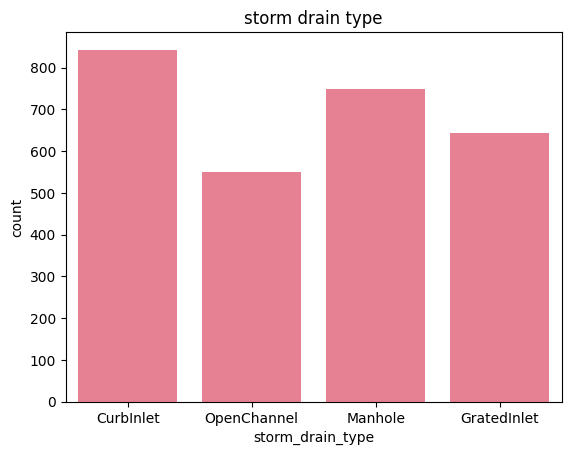

In [10]:
sns.countplot(x='storm_drain_type', data=df)
plt.title('storm drain type')
plt.show()

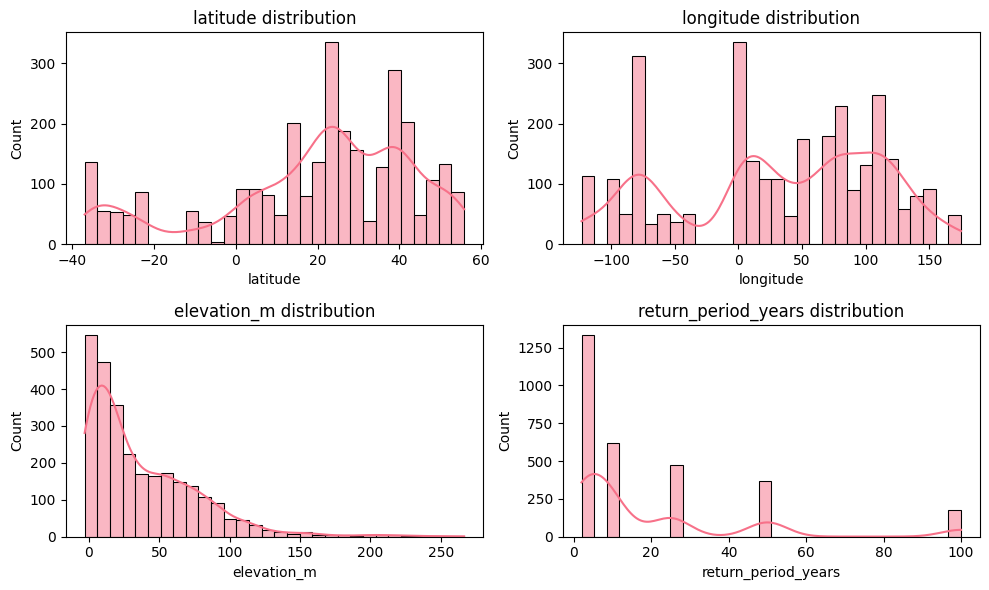

In [11]:
import math

num_cols = ["latitude","longitude","elevation_m","return_period_years"]
n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
axes = axes.ravel()

for ax, col in zip(axes, num_cols):
    sns.histplot(df[col].dropna(), ax=ax, kde=True, bins=30)
    ax.set_title(f"{col} distribution")

# remove empty axes if any
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

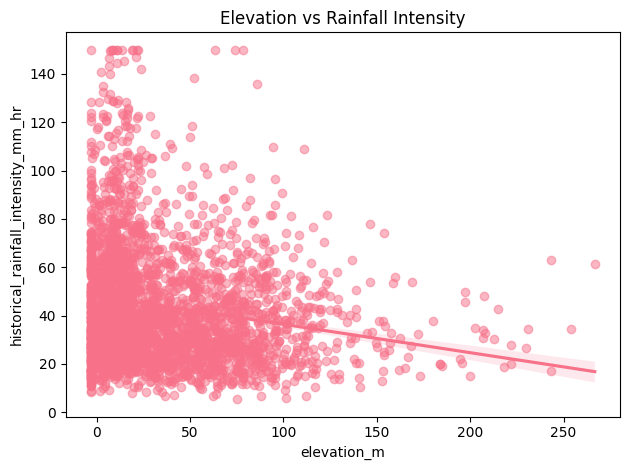

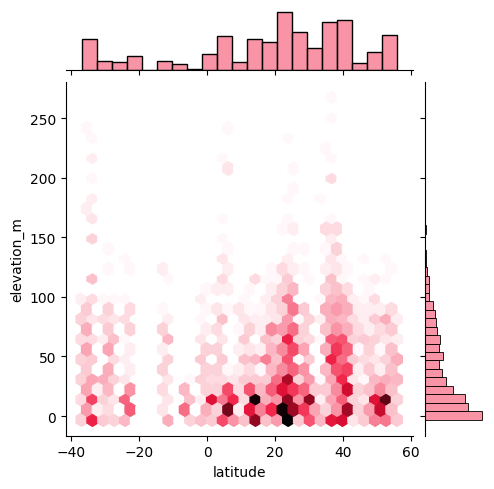

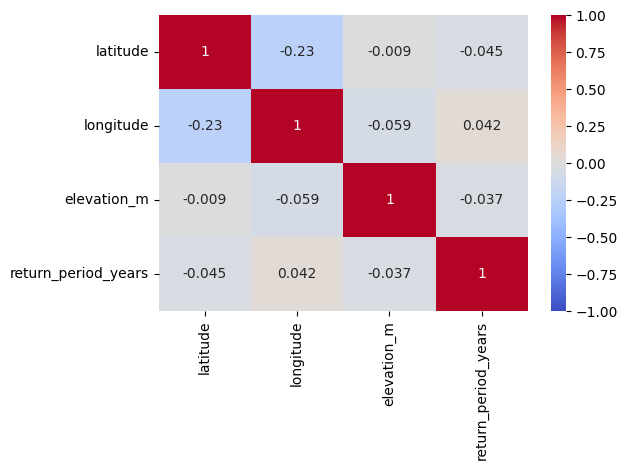

In [12]:
# Scatter + trend
sns.regplot(data=df, x="elevation_m", y="historical_rainfall_intensity_mm_hr", scatter_kws={"alpha":0.5})
plt.title("Elevation vs Rainfall Intensity"); plt.tight_layout(); plt.show()

# Joint distribution
sns.jointplot(data=df, x="latitude", y="elevation_m", kind="hex", height=5); plt.show()

# Correlation (subset)
cols = ["latitude","longitude","elevation_m","return_period_years"]
sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1); plt.tight_layout(); plt.show()


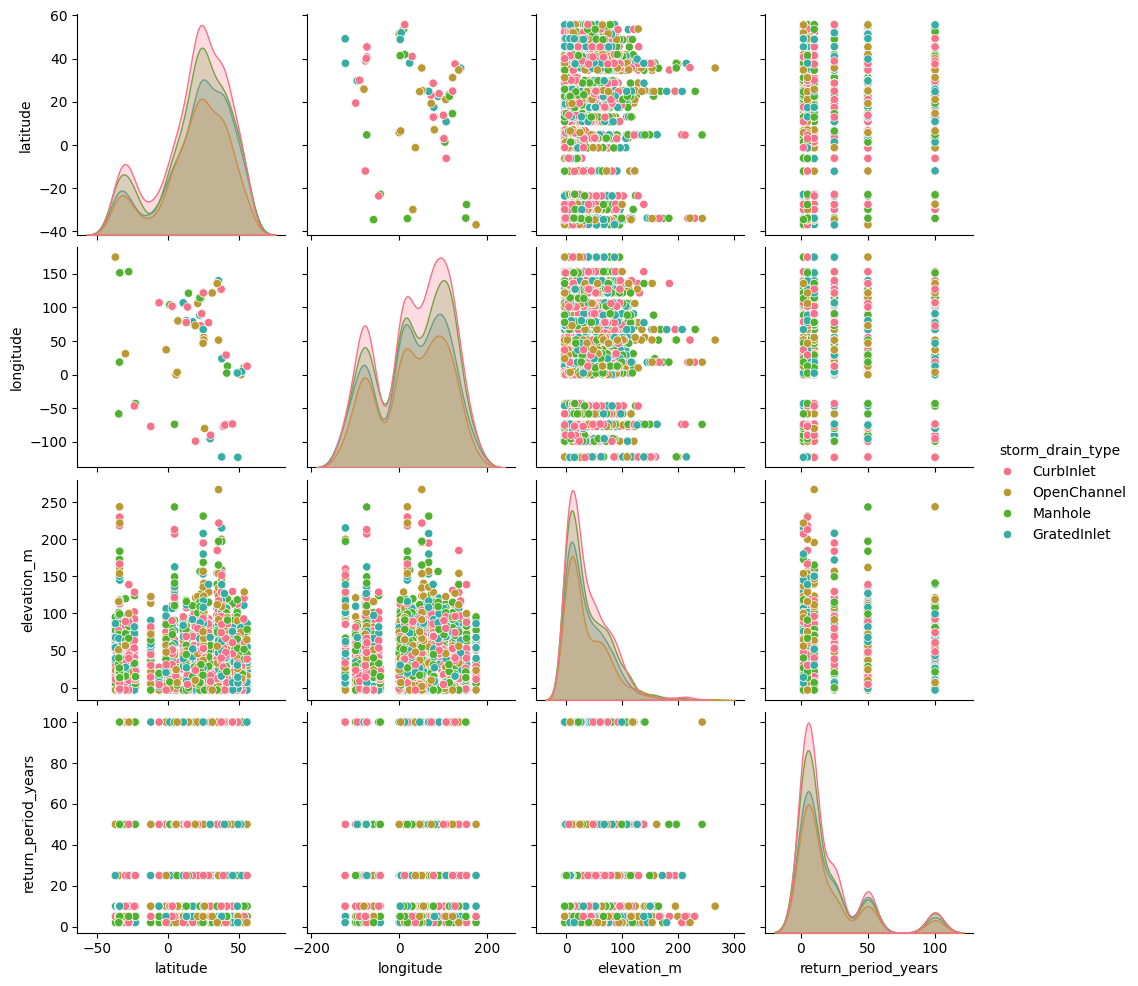

In [13]:
#pairplot
sns.pairplot(df, vars=num_cols, hue='storm_drain_type')
plt.show()

In [14]:
df.columns


Index(['segment_id', 'city_name', 'admin_ward', 'latitude', 'longitude',
       'catchment_id', 'elevation_m', 'dem_source', 'land_use', 'soil_group',
       'drainage_density_km_per_km2', 'storm_drain_proximity_m',
       'storm_drain_type', 'rainfall_source',
       'historical_rainfall_intensity_mm_hr', 'return_period_years',
       'risk_labels'],
      dtype='object')

In [29]:
#feature and target selection
X=df.drop('storm_drain_type',axis=1)
y=df['storm_drain_type']

In [17]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42
)



In [18]:
X_train.shape

(2370, 16)

In [19]:
X_test.shape



(593, 16)

In [20]:
#Scale  num features
scaler= StandardScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test[num_cols]=scaler.fit_transform(X_test[num_cols])

In [21]:
X_train

,segment_id,city_name,admin_ward,latitude,longitude,catchment_id,elevation_m,dem_source,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,rainfall_source,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
518,SEG-00519,35,61,-0.198217,1.125282,55,-0.650054,Copernicus_EEA-10_v5,7,2,7.21,116.0,3,45.6,-0.583100,monitor
2778,SEG-02779,35,5,-0.202199,1.124200,177,-0.653210,Copernicus_GLO-90_v2022,1,1,1.39,65.2,2,53.3,-0.385510,sparse_drainage|event_2024-03-18
573,SEG-00574,13,71,-0.511618,0.611610,126,-0.630854,SRTM_1arc,6,4,8.03,NaN,1,42.0,0.207261,monitor
2810,SEG-02811,24,75,0.125690,1.042004,30,-0.753679,SRTM_1arc,0,2,8.25,179.9,1,63.5,0.207261,monitor
2390,SEG-02391,18,88,0.235237,0.304609,120,NaN,SRTM_1arc,6,0,8.17,247.5,2,13.1,-0.385510,monitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,SEG-01639,43,0,0.616454,1.307846,130,1.585513,SRTM_3arc,0,3,10.51,NaN,1,29.6,-0.385510,monitor
1095,SEG-01096,37,40,0.259418,-1.391665,173,-0.849677,Copernicus_GLO-90_v2022,1,4,6.20,83.6,3,55.6,0.207261,low_lying
1130,SEG-01131,52,63,-1.758844,-0.970557,135,1.697028,SRTM_1arc,0,3,8.25,15.4,3,34.5,-0.701654,monitor
1294,SEG-01295,31,46,-0.664685,0.883967,95,1.356959,Copernicus_GLO-90_v2022,1,0,5.10,52.3,3,69.6,1.195213,monitor


In [22]:
# Data Preprocessing
print("--- Data Preprocessing ---")

# Handle missing values first
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Separate features and target
target_col = 'storm_drain_type'  # Target variable
features_to_drop = ['segment_id', 'city_name', 'admin_ward', 'catchment_id', 'risk_labels']
X = df.drop(columns=features_to_drop + [target_col])
y = df[target_col]

# Encode the target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Identify numerical and categorical features for the ColumnTransformer
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Data successfully preprocessed and split.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



--- Data Preprocessing ---
Data successfully preprocessed and split.
X_train shape: (2370, 11), y_train shape: (2370,)
X_test shape: (593, 11), y_test shape: (593,)



--- Correlation Matrix ---


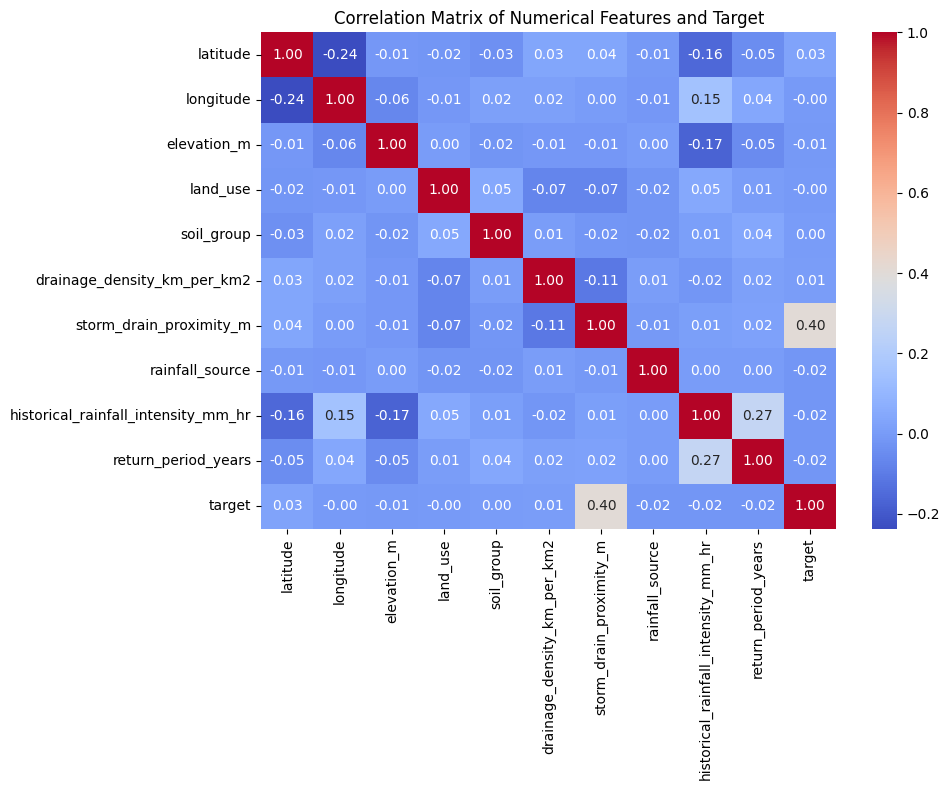

In [23]:
# Correlation Matrix of Numerical Features with the Target
print("\n--- Correlation Matrix ---")

# Make a copy of the preprocessed numerical data for correlation analysis
corr_df = X_train[numerical_cols].copy()
corr_df['target'] = y_train

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Target')
plt.tight_layout()
plt.show()


--- FIXED Model Training ---
Training Random Forest...
Training Logistic Regression...

--- FIXED Model Evaluation ---
Evaluating models...

Random Forest Evaluation:
Accuracy: 0.3238
Target classes: ['0', '1', '2', '3', '4']

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.49      0.40       169
           1       0.17      0.10      0.13       129
           2       0.29      0.29      0.29       150
           3       0.44      0.43      0.43       110
           4       0.38      0.17      0.24        35

    accuracy                           0.32       593
   macro avg       0.32      0.30      0.30       593
weighted avg       0.31      0.32      0.31       593



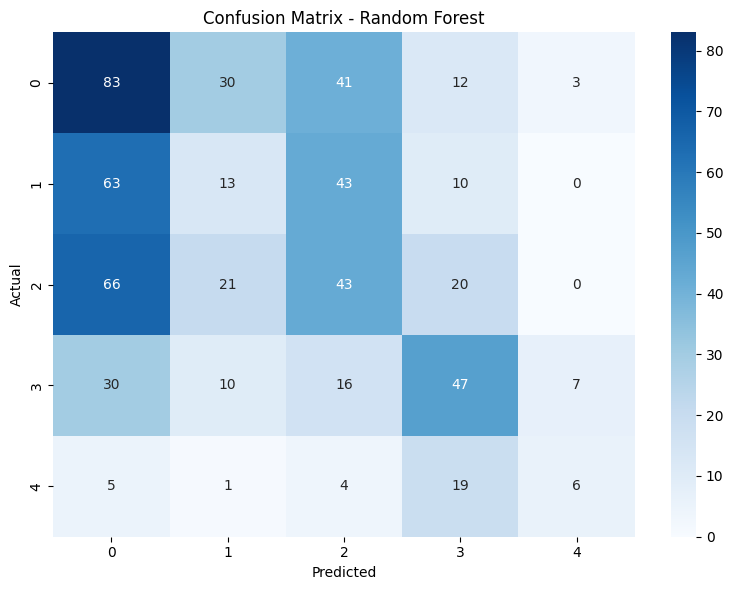


Logistic Regression Evaluation:
Accuracy: 0.3255
Target classes: ['0', '1', '2', '3', '4']

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.66      0.44       169
           1       0.31      0.06      0.10       129
           2       0.20      0.13      0.16       150
           3       0.39      0.45      0.42       110
           4       0.45      0.14      0.22        35

    accuracy                           0.33       593
   macro avg       0.34      0.29      0.27       593
weighted avg       0.31      0.33      0.28       593



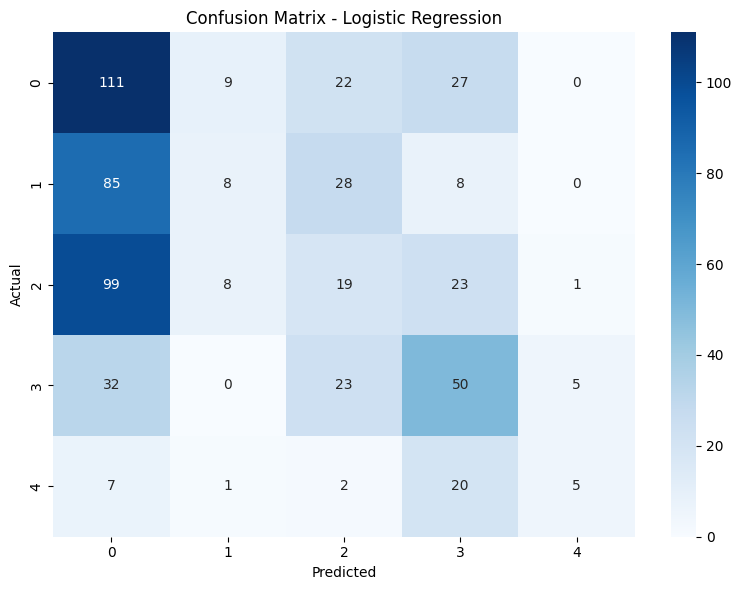


MODEL COMPARISON SUMMARY
Random Forest Accuracy: 0.3238
Logistic Regression Accuracy: 0.3255
🏆 Best Model: Logistic Regression (by 0.0017)


In [24]:
# FIXED: Model Training and Evaluation with proper target names handling
print("\n--- FIXED Model Training ---")

# Define pipelines for the models, including the preprocessor
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'))])

# Train the models
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

# --- Model Evaluation ---
print("\n--- FIXED Model Evaluation ---")

def evaluate_model_fixed(model, X_test, y_test, model_name, le_target):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")

    # FIX: Convert target_names to strings to avoid TypeError
    target_names = [str(name) for name in le_target.classes_]
    print(f"Target classes: {target_names}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return accuracy

# Evaluate both models on the test set
print("Evaluating models...")
rf_accuracy = evaluate_model_fixed(rf_pipeline, X_test, y_test, "Random Forest", le_target)
lr_accuracy = evaluate_model_fixed(lr_pipeline, X_test, y_test, "Logistic Regression", le_target)

# Compare models
print(f"\n{'='*50}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*50}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

if rf_accuracy > lr_accuracy:
    print(f"🏆 Best Model: Random Forest (by {rf_accuracy - lr_accuracy:.4f})")
else:
    print(f"🏆 Best Model: Logistic Regression (by {lr_accuracy - rf_accuracy:.4f})")


In [25]:
# Save the best model and components for deployment
print("Saving models for deployment...")

# Determine the best model
if rf_accuracy >= lr_accuracy:
    best_model = rf_pipeline
    best_model_name = "Random Forest"
    best_accuracy = rf_accuracy
else:
    best_model = lr_pipeline
    best_model_name = "Logistic Regression"
    best_accuracy = lr_accuracy

# Save the best model
joblib.dump(best_model, 'best_flood_risk_model.pkl')
print(f"✅ Saved best model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

# Save the preprocessor (this is what was missing before!)
joblib.dump(preprocessor, 'flood_risk_preprocessor.pkl')
print("✅ Saved preprocessor pipeline")

# Save the target label encoder
joblib.dump(le_target, 'flood_risk_label_encoder.pkl')
print("✅ Saved target label encoder")

# Also save a simple scaler for the app.py compatibility
# Extract the scaler from the preprocessor
scaler = preprocessor.named_transformers_['num']
joblib.dump(scaler, 'scaler.pkl')
print("✅ Saved scaler for app.py compatibility")

print(f"\n🎯 DEPLOYMENT FILES READY:")
print(f"   - best_flood_risk_model.pkl")
print(f"   - flood_risk_preprocessor.pkl") 
print(f"   - flood_risk_label_encoder.pkl")
print(f"   - scaler.pkl")
print(f"\n🚀 You can now run: streamlit run app.py")


Saving models for deployment...
✅ Saved best model: Logistic Regression (Accuracy: 0.3255)
✅ Saved preprocessor pipeline
✅ Saved target label encoder
✅ Saved scaler for app.py compatibility

🎯 DEPLOYMENT FILES READY:
   - best_flood_risk_model.pkl
   - flood_risk_preprocessor.pkl
   - flood_risk_label_encoder.pkl
   - scaler.pkl

🚀 You can now run: streamlit run app.py



--- Model Training ---
Training Random Forest...
Training Logistic Regression...

--- Model Evaluation ---

Random Forest Evaluation:
Accuracy: 0.3238

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.49      0.40       169
           1       0.17      0.10      0.13       129
           2       0.29      0.29      0.29       150
           3       0.44      0.43      0.43       110
           4       0.38      0.17      0.24        35

    accuracy                           0.32       593
   macro avg       0.32      0.30      0.30       593
weighted avg       0.31      0.32      0.31       593



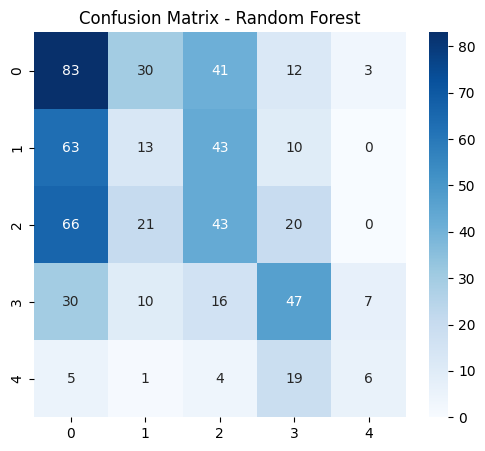


Logistic Regression Evaluation:
Accuracy: 0.3255

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.66      0.44       169
           1       0.31      0.06      0.10       129
           2       0.20      0.13      0.16       150
           3       0.39      0.45      0.42       110
           4       0.45      0.14      0.22        35

    accuracy                           0.33       593
   macro avg       0.34      0.29      0.27       593
weighted avg       0.31      0.33      0.28       593



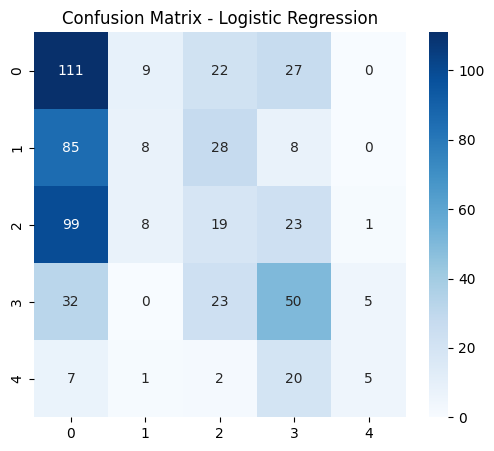

In [27]:
# --- Model Training ---
print("\n--- Model Training ---")

# Define pipelines for the models, including the preprocessor
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'))])

# Train the models
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

# --- Model Evaluation ---
print("\n--- Model Evaluation ---")

def evaluate_model(model, X_test, y_test, model_name, le_target):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")

    # Convert target_names to strings to avoid TypeError
    target_names = [str(name) for name in le_target.classes_]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Evaluate both models on the test set
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest", le_target)
evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression", le_target)


--- Model Tuning and Optimization ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Random Forest Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Random Forest CV Score: 0.3392

Tuned Random Forest Evaluation:
Accuracy: 0.3103

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.48      0.38       169
           1       0.14      0.07      0.09       129
           2       0.26      0.26      0.26       150
           3       0.45      0.44      0.44       110
           4       0.44      0.20      0.27        35

    accuracy                           0.31       593
   macro avg       0.32      0.29      0.29       593
weighted avg       0.30      0.31      0.29       593



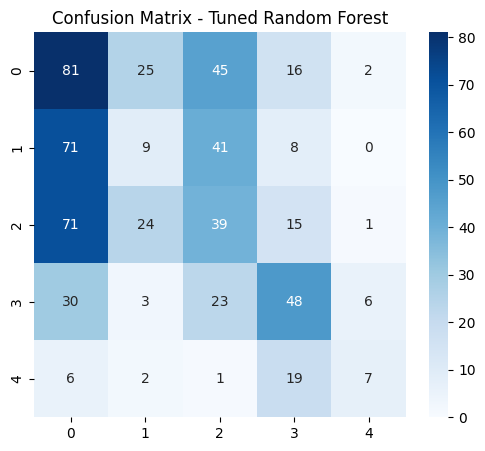

In [28]:
# --- Model Tuning and Optimization ---
print("\n--- Model Tuning and Optimization ---")

# Define parameter grid for Random Forest
# The parameters are prefixed with 'classifier__' because it's a pipeline
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Perform GridSearchCV with the Random Forest pipeline
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest CV Score: {rf_grid_search.best_score_:.4f}")

# Evaluate the tuned model
evaluate_model(rf_grid_search.best_estimator_, X_test, y_test, "Tuned Random Forest", le_target)

In [ ]:
# --- Final Model Testing & Saving ---
print("\n--- Final Model Testing & Saving ---")

# Select the best model (the one from the grid search)
best_model = rf_grid_search.best_estimator_
model_name = "Optimized Random Forest"

# Make final predictions on the unseen test set
y_pred_final = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Final Tuned Random Forest Test Accuracy: {final_accuracy:.4f}")

# Save the final model, preprocessor, and label encoder for deployment
model_filename = 'best_flood_risk_model.pkl'
preprocessor_filename = 'flood_risk_preprocessor.pkl'
label_encoder_filename = 'flood_risk_label_encoder.pkl'

joblib.dump(best_model, model_filename)
# The preprocessor is already part of the final model pipeline, so we don't need to save it separately.
# However, saving the label encoder is a good practice for decoding predictions.
joblib.dump(le_target, label_encoder_filename)

print(f"Final model saved as: {model_filename}")
print(f"Label encoder saved as: {label_encoder_filename}")



--- Final Model Testing & Saving ---
Final Tuned Random Forest Test Accuracy: 0.3491
Final model saved as: best_flood_risk_model.pkl
Label encoder saved as: flood_risk_label_encoder.pkl
